In [28]:
import pandas as pd
from os import path
import matplotlib.pyplot as plt
import seaborn as sns

## Employment occupation data by state for 2019

These are the OES research estimates by state. [https://www.bls.gov/oes/2019/may/oes_research_estimates.htm](https://www.bls.gov/oes/2019/may/oes_research_estimates.htm)

These are estimates and they do not appear to aggregae perfectly. We lose about sixe percent of total employment.  

In [29]:
if path.exists('intermediate/wi.csv') == False:
    df = pd.read_excel('data/oes_research_2019_allsectors.xlsx', na_values=['**', '*', '#'])
    wi = df[df.area==55]
    wi.to_csv('intermediate/wi.csv', index=False, header=True)
else:
    wi = pd.read_csv('intermediate/wi.csv', na_values=['**', '*', '#'])

In [30]:
wi.head(1)

,area,area_title,naics,naics_title,occ code,occ title,o_group,i_group,tot_emp,emp_prse,...,h_median,h_pct75,h_pct90,a_pct10,a_pct25,a_median,a_pct75,a_pct90,annual,hourly
0,55,Wisconsin,11,"Agriculture, Forestry, Fishing and Hunting",00-0000,All Occupations,total,sector,4000.0,11.3,...,18.69,26.25,36.27,24870.0,30950.0,38870.0,54600.0,75450.0,NaN,NaN


We lose some employment when we disaggregate.  The levels of aggregation are

In [31]:
print(wi.i_group.unique())
print(wi.o_group.unique())

['sector' '3-digit' '4-digit' '6-digit' '5-digit']
['total' 'major' 'detailed']


In [32]:
# This is very close to the website: https://www.bls.gov/oes/current/oes_wi.htm  = 2,870,050
tot00 = wi[(wi.i_group=='sector')&(wi['o_group']=='total')]['tot_emp'].sum().sum()
print(tot00)

2870060.0


In [33]:
# 3-digit industry and occ total
print(wi[(wi['i_group']=='3-digit') & (wi['o_group']=='total')]['tot_emp'].sum())
print(wi[(wi['i_group']=='3-digit') & (wi['o_group']=='total')]['tot_emp'].sum()/tot00)


2869660.0
0.999860630091357


In [34]:
# 3-digit and occ major
print(wi[(wi['i_group']=='3-digit') & (wi['o_group']=='major')]['tot_emp'].sum())
print(wi[(wi['i_group']=='3-digit') & (wi['o_group']=='major')]['tot_emp'].sum()/tot00)

2844250.0
0.9910071566448089


In [35]:
# 3-digit and occ detailed
print(wi[(wi['i_group']=='3-digit') & (wi['o_group']=='detailed')]['tot_emp'].sum())
print(wi[(wi['i_group']=='3-digit') & (wi['o_group']=='detailed')]['tot_emp'].sum()/tot00)

2690140.0
0.9373114150923674


In [36]:
# 2-digit and occ detailed
print(wi[(wi['i_group']=='sector') & (wi['o_group']=='detailed')]['tot_emp'].sum())
print(wi[(wi['i_group']=='sector') & (wi['o_group']=='detailed')]['tot_emp'].sum()/tot00)

2766550.0
0.9639345518909013


## Proximity score

This function creates the proximity variable for a given level of industry aggregation. It always uses the 'detailed' occupation codes.  

An issue is that the employment data uses the 2018 soc codes and the proximity data uses the 2010 codes. At the 4-digit level this only causes a few issues, which I address in the code. 

1. Fix up the soc codes in the employment data
2. Load the proximity code data and clean up the soc codes
3. Merge the proximity and employmnet data on soc code
4. Create an employment-weighted proximity index

In [37]:
def merge_prox(wi, ind_level):
    
    # Keep the 3-digit industries and detailed occupations. 
    # Convert the occupation codes to 4-digit
    wi = wi[(wi['i_group']=='3-digit') & (wi['o_group']=='detailed')].copy()
    wi['soc4'] = wi['occ code'].str.slice(0,5).str.replace('-', '') 
    
    if ind_level == '2-digit':
        wi['naics'] = wi['naics'].str.slice(0,2) 
        
    # Even at the 4-digit level, the 2018 and 2010 soc need some tweaks.
    wi.loc[wi['soc4']=='1512', 'soc4'] = '1511'         # Computer jobs
    wi.loc[wi['soc4']=='1950', 'soc4'] = '1940'         # Occupational health and saftey specialists
    wi.loc[wi['soc4']=='3111', 'soc4'] = '3110'         # Home health aides, nursing assistants, orderlies
    wi.loc[wi['soc4']=='2912', 'soc4'] = '2920'         # Dental hygenists

    wi = wi.groupby(['naics', 'soc4'])['tot_emp'].sum()
    wi = wi.reset_index()
    print('Total employment at this aggregation is {0:,}. \n'.format(wi['tot_emp'].sum().sum()))
    
    # Load the proximity data
    prox = pd.read_csv('data/Physical_Proximity.csv')
    prox['soc4'] = prox['Code'].str.slice(0,5).str.replace('-', '')
    prox = prox.groupby('soc4').mean()
    prox.columns = ['prox']
    prox = prox.reset_index()
    
    # Merge the two
    wi = pd.merge(left=prox, right=wi, on='soc4', how='outer', indicator=True)
    print('The output of this merge should have `right_only` = 0.')
    print(wi._merge.value_counts())
    wi = wi[wi['_merge']=='both']
    wi = wi.drop('_merge', axis=1)
    
    # Create the weighted index
    wi = wi.set_index(['naics', 'soc4'])
    wi = wi.unstack('soc4')
    
    wi[('tot_emp','ind_tot')] = wi['tot_emp'].sum(axis=1)
    for c in wi['tot_emp'].columns:
        wi[('share', c)] = wi[('tot_emp', c)]/wi[('tot_emp', 'ind_tot')]
        
    wi = wi.drop([('tot_emp', 'ind_tot'),('share', 'ind_tot')], axis=1)
    wi = wi.stack()
    wi['wt'] = wi['prox']*wi['share']
    
    wi.to_csv('intermediate/'+ind_level+'dist.csv')
    
    wi = wi.groupby(['naics'])[['tot_emp','wt']].sum().sort_values('wt')
    wi.columns = ['employment', 'proximity']
    wi['emp_share'] = wi['employment']/(wi['employment'].sum())*100
    return wi

## Two-digit results

1. Table for paper
2. Figure not used in paper, but for slides
3. csv of all industries

First, we create the data. Then, we need to add the labels back to the data. This is a bit trickier because I want two-digit industries rather than the multi-industry groups that exist for 31-33, 48-49, 44-45.

In [38]:
naics2 = merge_prox(wi, '2-digit')

Total employment at this aggregation is 2,690,140.0. 

The output of this merge should have `right_only` = 0.
both          1125
left_only        2
right_only       0
Name: _merge, dtype: int64


In [39]:
labels2 = pd.read_csv('intermediate/wi.csv')
labels2 = labels2[labels2['i_group']=='sector'].groupby('naics').first()
naics2 = pd.merge(left=naics2, right=labels2['naics_title'], left_index=True, right_index=True, how='left')

In [40]:
naics2.loc['31', 'naics_title']= 'food, textiles, apparel manufacturing'
naics2.loc['32', 'naics_title']= 'wood, paper, petroleum, chemical, mineral manufacturing'
naics2.loc['33', 'naics_title']= 'metal, computer, electrical, transport manufacturing'

naics2.loc['48', 'naics_title']= 'transportation'
naics2.loc['49', 'naics_title']= 'couriers, warehousing, storage'

naics2.loc['44', 'naics_title']= 'specialize retail'
naics2.loc['45', 'naics_title']= 'general merchandise retail'

# Thes two have really long descriptions, so I tweaked them.
naics2.loc['99', 'naics_title']= 'federal, state, local government'
naics2.loc['56', 'naics_title']= 'administrative support'

In [41]:
naics2 = naics2.reset_index()
naics2.to_csv('outputs/naics2_proximity.csv', index=False)
naics2.head(1)

,naics,employment,proximity,emp_share,naics_title
0,11,2990.0,49.8311,0.111147,"Agriculture, Forestry, Fishing and Hunting"


In [42]:
tab = '\caption{Proximity score by industry (0 = lowest exposure).}'

tab = tab + '''\\label{tab:2-digit}
\\footnotesize
\\begin{tabular*}{0.8\\textwidth}{cl@{\\extracolsep{\\fill}}cc}
\\toprule
Code & Industry & Score & Emp. share\\\\
\\midrule
'''

for i, r in naics2.sort_values('proximity', ascending=False).iterrows():
    tab = (tab + str(r['naics']) + '&' + str(r['naics_title']).capitalize() + '&' + 
    '{:3.1f}'.format(r.proximity) + '&'+'{:3.1f}'.format(r.emp_share)+ '\\\\' + '\n')
    
tab = tab + '\\bottomrule' + '\n' + '\\end{tabular*}'
print(tab)

with open("outputs/naics2.txt", "w") as text_file:
    print('{}'.format(tab), file=text_file)

\caption{Proximity score by industry (0 = lowest exposure).}\label{tab:2-digit}
\footnotesize
\begin{tabular*}{0.8\textwidth}{cl@{\extracolsep{\fill}}cc}
\toprule
Code & Industry & Score & Emp. share\\
\midrule
62&Health care and social assistance&77.3&14.9\\
72&Accommodation and food services&71.1&8.9\\
48&Transportation&67.7&2.5\\
71&Arts, entertainment, and recreation&66.9&1.6\\
61&Educational services&65.6&8.0\\
23&Construction&65.5&4.5\\
81&Other services (except public administration)&64.9&2.8\\
44&Specialize retail&63.5&7.1\\
21&Mining, quarrying, and oil and gas extraction&63.0&0.1\\
45&General merchandise retail&62.5&3.5\\
99&Federal, state, local government&62.0&5.7\\
22&Utilities&59.0&0.3\\
53&Real estate and rental and leasing&58.9&0.9\\
49&Couriers, warehousing, storage&58.1&1.2\\
31&Food, textiles, apparel manufacturing&58.0&2.9\\
33&Metal, computer, electrical, transport manufacturing&55.9&8.7\\
56&Administrative support&55.4&5.2\\
51&Information&55.3&1.2\\
32&Wood, pape

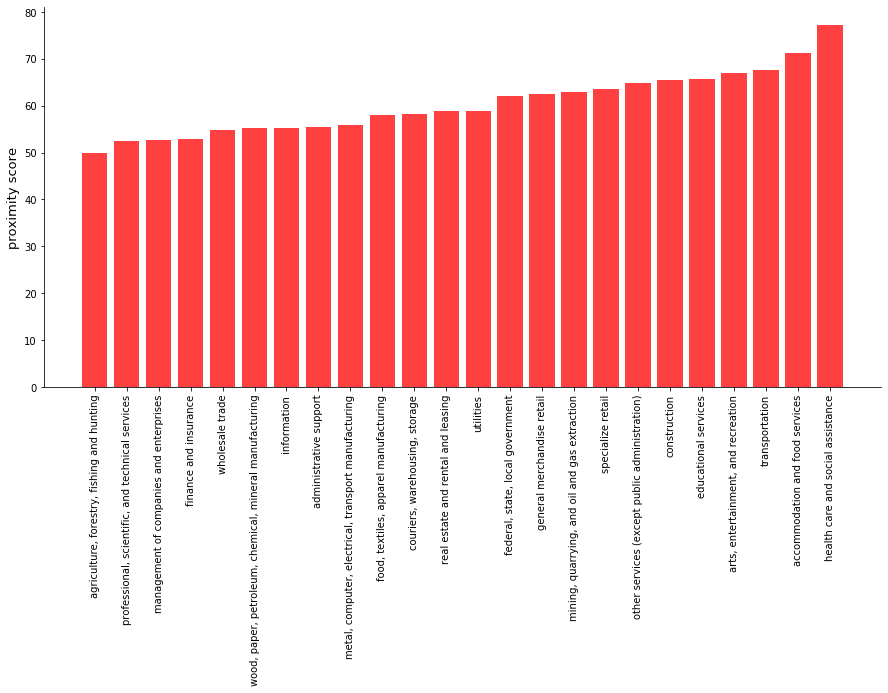

In [43]:
fig, ax = plt.subplots(figsize=(15,7))

ax.bar(naics2['naics_title'].str.lower(), naics2['proximity'], color='red', alpha=0.75)

ax.tick_params(axis='x', which='major', rotation=90)

ax.set_ylabel('proximity score', fontsize=13)

fig.savefig('outputs/two-dig-bar.pdf', bbox_inches='tight')

sns.despine(ax=ax)

## Three digit results

1. Employment by sector and proximity scores
2. Best and worst 
3. csv of all industries

We need to add the NAICS labels back to the data. They were dropped during the reshaping involved in making the proximity score. We want `left_only`=0. 

In [44]:
naics3 = merge_prox(wi, '3-digit')

Total employment at this aggregation is 2,690,140.0. 

The output of this merge should have `right_only` = 0.
both          2237
left_only        2
right_only       0
Name: _merge, dtype: int64


In [45]:
labels = pd.read_csv('intermediate/wi.csv')
labels = labels[labels['i_group']=='3-digit'].groupby('naics').first()

naics3 = pd.merge(left=naics3, right=labels['naics_title'], left_on='naics', right_index=True, how = 'left')

naics3 = naics3.reset_index()

naics3.to_csv('outputs/naics3_proximity.csv', index=False)

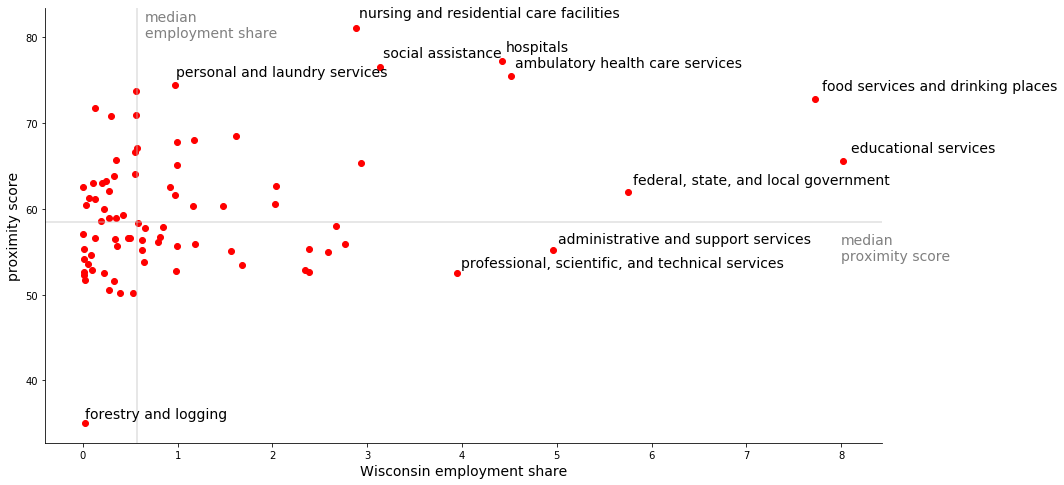

In [46]:
fig, ax = plt.subplots(figsize=(15,8))

ax.scatter(naics3['emp_share'], naics3['proximity'], color='red')

ax.set_xlabel('Wisconsin employment share', fontsize=14)
ax.set_ylabel('proximity score', fontsize=14)

# Label some of the points
for x,y,t in zip(naics3['emp_share'], naics3['proximity'], naics3['naics_title']):
    if (x > 3) or (y > 74) or(y < 40):
        if t[0:14] == 'Federal, State':
            t = 'Federal, State, and Local Government'
        ax.text(x*1.01, y*1.015, t.lower(), fontsize=14)

# Add the median lines
ax.axhline(naics3['proximity'].median(), color='silver', alpha=0.5)
ax.axvline(naics3['emp_share'].median(), color='silver', alpha=0.5)

ax.text(8, 54, 'median\nproximity score', color='grey', fontsize=14)
ax.text(0.65, 80, 'median\nemployment share', color='grey', fontsize=14)
        
sns.despine(ax=ax)

plt.savefig('outputs/prox-emp-scatter.pdf', bbox_inches='tight')
plt.show()

In [47]:
tab = '\caption{Highest 10: Proximity score by industry (0 = lowest exposure).}'

tab = tab + '''\\label{tab:3-digit-top}
\\footnotesize
\\begin{tabular*}{0.8\\textwidth}{lp{3in}@{\\extracolsep{\\fill}}cc}
\\toprule
Code & Industry & Score & Emp. share \\\\
\\midrule
'''

for i, r in naics3.sort_values('proximity', ascending=False).head(10).iterrows():
    tab = (tab + str(r['naics'][0:3]) + '&' + str(r.naics_title).capitalize() + '&' + 
           '{:3.1f}'.format(r.proximity) + '&' + '{:3.1f}'.format(r.emp_share) + '\\\\' + '\n')
    
tab = tab + '\\bottomrule' + '\n' + '\\end{tabular*}'
print(tab)

with open("outputs/ind3-highest.txt", "w") as text_file:
    print('{}'.format(tab), file=text_file)

\caption{Highest 10: Proximity score by industry (0 = lowest exposure).}\label{tab:3-digit-top}
\footnotesize
\begin{tabular*}{0.8\textwidth}{lp{3in}@{\extracolsep{\fill}}cc}
\toprule
Code & Industry & Score & Emp. share \\
\midrule
623&Nursing and residential care facilities&81.1&2.9\\
622&Hospitals&77.2&4.4\\
624&Social assistance&76.5&3.1\\
621&Ambulatory health care services&75.4&4.5\\
812&Personal and laundry services&74.4&1.0\\
446&Health and personal care stores&73.8&0.6\\
722&Food services and drinking places&72.8&7.7\\
512&Motion picture and sound recording industries&71.8&0.1\\
485&Transit and ground passenger transportation&70.9&0.6\\
492&Couriers and messengers&70.8&0.3\\
\bottomrule
\end{tabular*}


In [48]:
tab = '\caption{Lowest 10: Proximity score by industry (0 = lowest exposure).}'

tab = tab + '''\\label{tab:3-digit-top}
\\footnotesize
\\begin{tabular*}{0.8\\textwidth}{lp{3in}@{\\extracolsep{\\fill}}cc}
\\toprule
Code & Industry & Score & Emp. share \\\\
\\midrule
'''

for i, r in naics3.sort_values('proximity', ascending=False).tail(10).iterrows():
    tab = (tab + str(r['naics'][0:3]) + '&' + str(r.naics_title).capitalize() + '&' + 
           '{:3.1f}'.format(r.proximity) + '&' + '{:3.1f}'.format(r.emp_share) + '\\\\' + '\n')
    
tab = tab + '\\bottomrule' + '\n' + '\\end{tabular*}'
print(tab)

with open("outputs/ind3-lowest.txt", "w") as text_file:
    print('{}'.format(tab), file=text_file)

\caption{Lowest 10: Proximity score by industry (0 = lowest exposure).}\label{tab:3-digit-top}
\footnotesize
\begin{tabular*}{0.8\textwidth}{lp{3in}@{\extracolsep{\fill}}cc}
\toprule
Code & Industry & Score & Emp. share \\
\midrule
551&Management of companies and enterprises&52.6&2.4\\
425&Wholesale electronic markets and agents and brokers&52.5&0.2\\
541&Professional, scientific, and technical services&52.5&4.0\\
533&Lessors of nonfinancial intangible assets (except copyrighted works)&52.3&0.0\\
519&Other information services&51.7&0.0\\
511&Publishing industries (except internet)&51.6&0.3\\
518&Data processing, hosting, and related services&50.5&0.3\\
493&Warehousing and storage&50.2&0.5\\
523&Securities, commodity contracts, and other financial investments and related activities&50.2&0.4\\
113&Forestry and logging&35.0&0.0\\
\bottomrule
\end{tabular*}


## Numbers used in the text

Industries and occupations used as examples.

In [49]:
examples = ['611000', '722000']
naics3[naics3.naics.isin(examples)]

,naics,employment,proximity,emp_share,naics_title
65,611000,215880.0,65.608908,8.024861,Educational Services
75,722000,207760.0,72.768185,7.723018,Food Services and Drinking Places


In [50]:
# Size of the healthcare sector
health=['nursing and residential care facilities', 'social assistance', 'hospitals',
        'ambulatory health care services', 'social assistance']

naics3[naics3.naics_title.str.lower().isin(health)].emp_share.sum()

14.947549198182994

Here, we load an intermediate DataFrame created in `merge_prox()` that has the distribution of employmnet within an industry. 

In [51]:
dist = pd.read_csv('intermediate/3-digitdist.csv')

In [52]:
# Food services and drinking places
dist[dist['naics']==722000].sort_values('share')

,naics,soc4,prox,tot_emp,share,wt
2046,722000,5370,47.533333,0.0,0.000000,0.000000
2041,722000,4340,59.333333,0.0,0.000000,0.000000
2029,722000,1320,47.333333,40.0,0.000193,0.009113
2030,722000,1511,47.538462,40.0,0.000193,0.009153
2039,722000,4130,54.285714,50.0,0.000241,0.013065
2037,722000,4110,54.500000,60.0,0.000289,0.015739
2028,722000,1311,49.000000,120.0,0.000578,0.028302
2044,722000,5130,64.857143,310.0,0.001492,0.096774
2031,722000,3390,68.000000,670.0,0.003225,0.219291
2040,722000,4330,56.000000,680.0,0.003273,0.183288


In [53]:
# Warehousing and storage
dist[dist['naics']==493000].sort_values('share')

,naics,soc4,prox,tot_emp,share,wt
1211,493000,4930,55.266667,0.0,0.000000,0.000000
1209,493000,4720,69.058824,0.0,0.000000,0.000000
1216,493000,5330,73.857143,0.0,0.000000,0.000000
1193,493000,1191,48.176471,30.0,0.002122,0.102213
1195,493000,1311,49.000000,30.0,0.002122,0.103960
1204,493000,4341,61.500000,40.0,0.002829,0.173975
1214,493000,5190,54.250000,40.0,0.002829,0.153465
1198,493000,3390,68.000000,40.0,0.002829,0.192362
1196,493000,1320,47.333333,60.0,0.004243,0.200849
1210,493000,4910,69.000000,60.0,0.004243,0.292786


In [54]:
# Educational services
dist[dist['naics']==611000].sort_values('share')

,naics,soc4,prox,tot_emp,share,wt
1700,611000,4930,55.266667,0.0,0.000000,0.000000
1696,611000,4520,50.142857,0.0,0.000000,0.000000
1680,611000,3590,74.666667,40.0,0.000185,0.013835
1673,611000,3120,90.500000,40.0,0.000185,0.016769
1692,611000,4350,60.066667,40.0,0.000185,0.011130
...,...,...,...,...,...,...
1661,611000,2511,52.615385,8710.0,0.040346,2.122846
1660,611000,2510,47.478261,17180.0,0.079581,3.778379
1663,611000,2530,79.000000,19640.0,0.090976,7.187141
1665,611000,2590,58.600000,23500.0,0.108857,6.379007
